# Biodiversity Intelligence Demo (GBIF)

Local, lightweight end‑to‑end demo

In [1]:
!pip install pygbif


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:

import pandas as pd
import numpy as np
from pygbif import occurrences
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


## Define Area of Interest

In [3]:

AOI = {
    "min_lat": 47.30,
    "max_lat": 47.45,
    "min_lon": 8.45,
    "max_lon": 8.65
}


## Load GBIF Sample

In [4]:

response = occurrences.search(
    decimalLatitude=f"{AOI['min_lat']},{AOI['max_lat']}",
    decimalLongitude=f"{AOI['min_lon']},{AOI['max_lon']}",
    taxonKey=6,
    hasCoordinate=True,
    limit=800
)
df = pd.DataFrame(response["results"])
df = df[["species","decimalLatitude","decimalLongitude","eventDate"]].dropna()
df["eventDate"] = pd.to_datetime(df["eventDate"], errors="coerce")
df = df.dropna()
df.head()


,species,decimalLatitude,decimalLongitude,eventDate
0,Ranunculus bulbosus,47.41814,8.53190,2026-01-06
1,Pseudosasa japonica,47.39841,8.51491,2026-01-06
2,Plantago lanceolata,47.41814,8.53190,2026-01-06
3,Ficaria verna,47.41814,8.53190,2026-01-06
4,Polygaloides chamaebuxus,47.32821,8.53006,2026-01-01


## Geospatial Processing

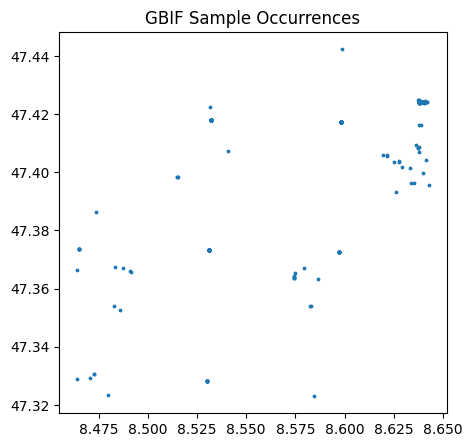

In [5]:

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.decimalLongitude, df.decimalLatitude),
    crs="EPSG:4326"
)
gdf.plot(markersize=3, figsize=(5,5))
plt.title("GBIF Sample Occurrences")
plt.show()


## Biodiversity Metrics

In [6]:

grid = 0.01
gdf["lat_bin"] = (gdf.decimalLatitude / grid).round() * grid
gdf["lon_bin"] = (gdf.decimalLongitude / grid).round() * grid

metrics = gdf.groupby(["lat_bin","lon_bin"]).agg(
    species_richness=("species","nunique"),
    observations=("species","count")
).reset_index()

metrics.head()


,lat_bin,lon_bin,species_richness,observations
0,47.32,8.48,1,1
1,47.32,8.58,1,1
2,47.33,8.46,1,1
3,47.33,8.47,1,3
4,47.33,8.53,7,9


## TNFD‑style Risk Proxy:Taskforce on Nature-related Financial Disclosures

In [7]:

threshold = metrics.species_richness.quantile(0.75)
metrics["high_risk"] = (metrics.species_richness > threshold).astype(int)

X = metrics[["species_richness","observations"]]
y = metrics["high_risk"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

model = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=42)
model.fit(X_train,y_train)

metrics["risk_score"] = (model.predict_proba(X)[:,1]*100).round(1)
metrics.head()


,lat_bin,lon_bin,species_richness,observations,high_risk,risk_score
0,47.32,8.48,1,1,0,0.0
1,47.32,8.58,1,1,0,0.0
2,47.33,8.46,1,1,0,0.0
3,47.33,8.47,1,3,0,0.0
4,47.33,8.53,7,9,1,86.0


## Risk Map

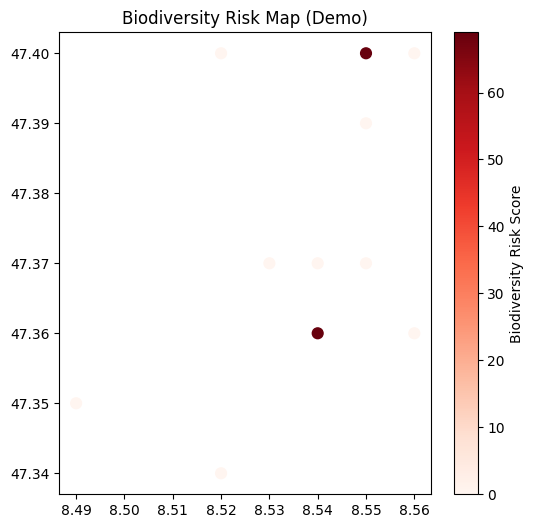

In [11]:

plt.figure(figsize=(6,6))
plt.scatter(metrics.lon_bin,metrics.lat_bin,c=metrics.risk_score,cmap="Reds",s=60)
plt.colorbar(label="Biodiversity Risk Score")
plt.title("Biodiversity Risk Map (Demo)")
plt.show()


## Executive Summary

In [8]:

{
    "mean_risk": float(metrics.risk_score.mean()),
    "max_risk": float(metrics.risk_score.max()),
    "high_risk_cells": int((metrics.risk_score>70).sum()),
    "confidence": 0.85
}


{'mean_risk': 20.2,
 'max_risk': 100.0,
 'high_risk_cells': 6,
 'confidence': 0.85}